In [1]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch

from models.hmappose import HmapPose
from models.datasets.lsp import LSPet, LSP

import numpy as np
from vis import show_pose_from_hmap, show_hmap

from torch.utils.tensorboard import SummaryWriter

In [2]:
# Load data
batch_size = 8

image_size = (256, 256)
hmap_size = 32

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

lsp = LSPet('./dataset/lspet_dataset/', transform, image_size, hmap_size)
lsp_loader = DataLoader(lsp, batch_size, shuffle=True, num_workers=1)

In [3]:
# Initialize the model
model = HmapPose().cuda()

model.load_state_dict(torch.load('./weights/hmappose9.weights'))

criterion = torch.nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [4]:
# Add network into tensorboard
data = next(iter(lsp_loader))

tb = SummaryWriter()
tb.add_graph(model, data[0].cuda())
# tb.close()

In [5]:
# Train the model
for epoch in range(10):
    for batch, batch_data in enumerate(lsp_loader):

        model.zero_grad()

        input_image = batch_data[0].cuda()
        joints_hmap = batch_data[1].cuda()
        

        prediction = model(input_image)

        loss = criterion(prediction, joints_hmap)
        loss.backward()
        optimizer.step()

        # Tensorboard
        tb.add_scalar('Loss', loss, 1250*epoch + batch)

        if batch % 100 == 0:
            print('Batch: {}, Loss: {}, Epoch: {}'.format(batch, loss, epoch))
            # Add keypoints loss of testing data
    
    # Tensorboard
    for name, weight in model.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)        

    torch.cuda.empty_cache()
    torch.save(model.state_dict(), './weights/hmappose{}.weights'.format(epoch))

tb.close()

Batch: 0, Loss: 0.024815993383526802, Epoch: 0
Batch: 100, Loss: 0.01680389977991581, Epoch: 0
Batch: 200, Loss: 0.016207214444875717, Epoch: 0
Batch: 300, Loss: 0.01517739612609148, Epoch: 0
Batch: 400, Loss: 0.014302103780210018, Epoch: 0
Batch: 500, Loss: 0.012495995499193668, Epoch: 0
Batch: 600, Loss: 0.013198578730225563, Epoch: 0
Batch: 700, Loss: 0.013278993777930737, Epoch: 0
Batch: 800, Loss: 0.015633800998330116, Epoch: 0
Batch: 900, Loss: 0.011218830943107605, Epoch: 0
Batch: 1000, Loss: 0.011436063796281815, Epoch: 0
Batch: 1100, Loss: 0.012904535047709942, Epoch: 0
Batch: 1200, Loss: 0.010535979643464088, Epoch: 0
Batch: 0, Loss: 0.010701313614845276, Epoch: 1
Batch: 100, Loss: 0.012943252921104431, Epoch: 1
Batch: 200, Loss: 0.011505238711833954, Epoch: 1
Batch: 300, Loss: 0.012093985453248024, Epoch: 1
Batch: 400, Loss: 0.012935738079249859, Epoch: 1
Batch: 500, Loss: 0.011387505568563938, Epoch: 1
Batch: 600, Loss: 0.009395011700689793, Epoch: 1
Batch: 700, Loss: 0.014

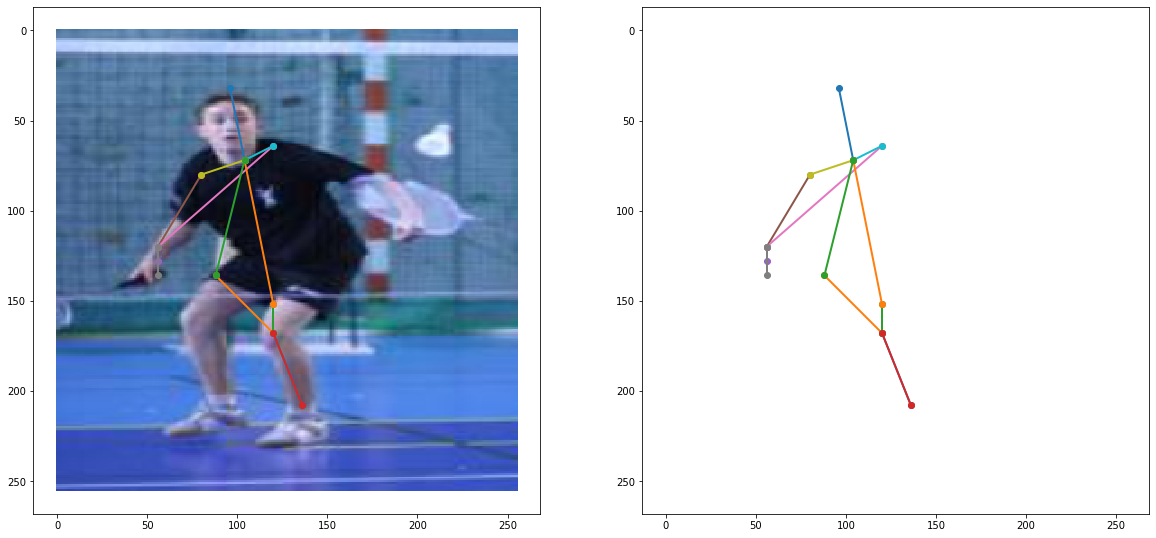

In [54]:
lsp_test = LSP('./dataset/lsp_dataset/', transform, image_size, hmap_size)
test_image, hmap, *_ = lsp_test.__getitem__(np.random.randint(len(lsp_test)))
test_predictions =  model(test_image.unsqueeze(0).cuda())
show_pose_from_hmap(test_image, test_predictions.squeeze()[:14,:,:].cpu().detach())
# show_hmap(test_image, test_predictions.squeeze().cpu().detach())

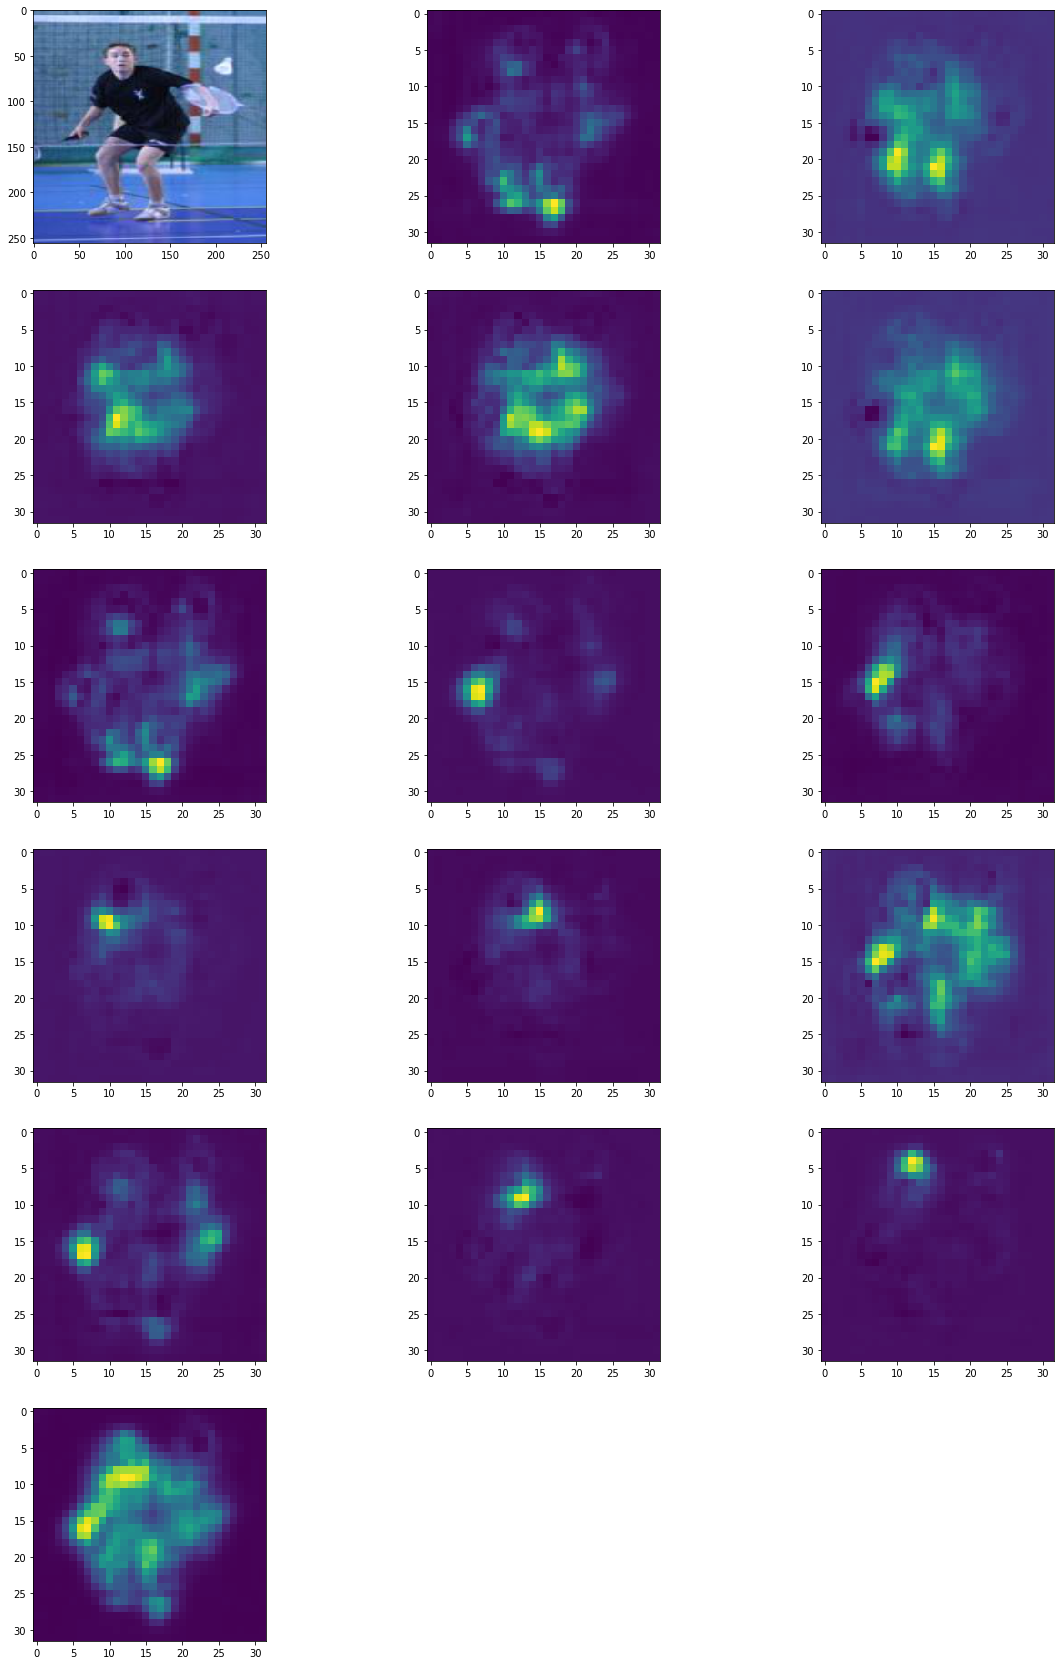

In [55]:
show_hmap(test_image, test_predictions.squeeze().cpu().detach())